In [1]:
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import string

from shared_functions import update_accuracy_in_config

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Load stopwords once
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package punkt to /Users/ashwal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ashwal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:


def custom_tokenizer(text, stop_words=stop_words):
    """
    Tokenize the input text and filter out stop words and non-alphanumeric tokens.

    Args:
        text (str): The input text to be tokenized.
        stop_words (set): A set of stop words to be excluded from the tokens (default is English stop words).

    Returns:
        list: A list of tokens that are alphanumeric and not in the stop words set.
    """
    # Convert text to lowercase and tokenize
    tokens = word_tokenize(text.lower())
    # Filter tokens: keep only alphanumeric tokens not in the stop words
    return [token for token in tokens if token.isalnum() and token not in stop_words]

def tokenizer(text):
    """
    Tokenize the input text using the custom tokenizer function.

    Args:
        text (str): The input text to be tokenized.

    Returns:
        list: A list of tokens processed by the custom tokenizer function.
    """
    return custom_tokenizer(text)



In [3]:
# Load dataset
df = pd.read_csv('../sampled_data.csv', header=None, names=['text', 'label'], delimiter=',', quoting=3)

# Split data into features and labels
X = df['text']
y = df['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline
pipeline = Pipeline([
    ('count', CountVectorizer(tokenizer=tokenizer, ngram_range=(1, 2))),
    ('clf', SVC(kernel='linear', random_state=42))  # You can change kernel if needed
])

# Define parameter grid for GridSearchCV
param_grid = {
    'count__max_features': [5000, 10000],
    'clf__C': [0.1, 1, 10]  # Regularization parameter for SVM
}

# Perform GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get best model
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 6 candidates, totalling 30 fits


/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sk

In [4]:


# Save the model to a .pkl file
file_name = '../trained_models/SVM_CV.pkl'
joblib.dump(best_model, file_name)

# Load the model from a .pkl file
loaded_model = joblib.load(file_name)

# Predict on the test set
y_pred = loaded_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))


update_accuracy_in_config(accuracy, 'count_svm')



Accuracy: 0.8166666666666667
Classification Report:
              precision    recall  f1-score   support

       anger       0.90      0.81      0.85       118
        fear       0.83      0.74      0.78        99
         joy       0.71      0.73      0.72        96
        love       0.91      0.87      0.89       101
     sadness       0.70      0.79      0.74        91
    surprise       0.85      0.96      0.90        95

    accuracy                           0.82       600
   macro avg       0.82      0.82      0.81       600
weighted avg       0.82      0.82      0.82       600



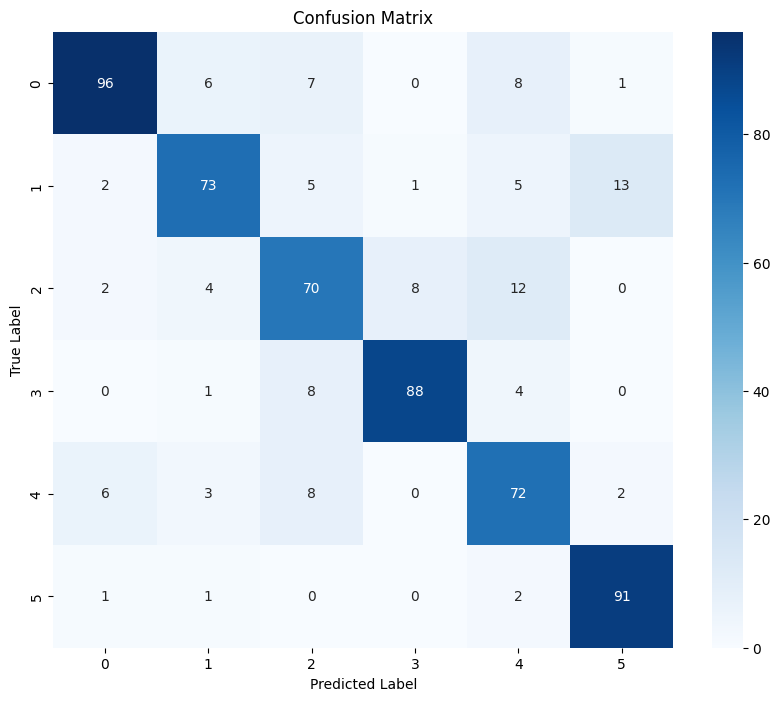

Text: I am so excited about the upcoming vacation!
Predicted Emotion: joy

Text: I feel completely overwhelmed with work right now.
Predicted Emotion: surprise

Text: The kids are really making me angry today.
Predicted Emotion: anger



In [5]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Test the model with new examples
new_examples = [
    "I am so excited about the upcoming vacation!",
    "I feel completely overwhelmed with work right now.",
    "The kids are really making me angry today."
]

# Predict emotions for the new examples
predictions = loaded_model.predict(new_examples)

# Output predictions
for example, prediction in zip(new_examples, predictions):
    print(f"Text: {example}")
    print(f"Predicted Emotion: {prediction}")
    print()

